# Spark Demo

In [1]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Window, WindowSpec, Row
from pyspark.sql.functions import lag, to_date, to_timestamp

## Creating a Spark Session
`SparkSession`is the entry point to interact with the underlying Spark functionality and configuration.

In [2]:
appName = 'Mirabaud Demo'

spark = SparkSession \
    .builder \
    .appName(appName) \
    .getOrCreate()

spark.sparkContext.setLogLevel('INFO')
spark.conf.set('spark.sql.shuffle.partitions', '4')

## Creating a DataFrame containing the raw data
A `DataFrame`is a distributed collection of data, which is organized into named columns. Conceptually, it is equivalent to relational tables with good optimization techniques.
### Reading from a CSV file
We can create a `DataFrame`directly reading from a text file, like a CSV file:

In [3]:
raw_df = spark \
    .read \
    .format('csv') \
    .options(header='true', inferSchema='true', delimiter=';', dateFormat='yyyy.MM.dd') \
    .load('./perf-example.csv')

raw_df.printSchema()
raw_df.show(25)

root
 |-- date: string (nullable = true)
 |-- estimation: double (nullable = true)
 |-- apport: double (nullable = true)

+----------+----------+-------+
|      date|estimation| apport|
+----------+----------+-------+
|31.12.2018|6318450.97|   null|
|01.01.2019|6318450.67|   null|
|02.01.2019|6316540.41|   null|
|03.01.2019| 6304647.2|   null|
|04.01.2019|6370469.52|   null|
|05.01.2019|6370469.16|   null|
|06.01.2019| 6370468.8|   null|
|07.01.2019| 6385205.4|   null|
|08.01.2019| 6413834.2|   null|
|09.01.2019|6449599.76|   null|
|10.01.2019|6477841.58|   null|
|11.01.2019|6485556.17|   null|
|12.01.2019|6485553.38|   null|
|13.01.2019|6485550.59|   null|
|14.01.2019|6463355.41|   null|
|15.01.2019|6505456.63|   null|
|16.01.2019|6532307.64|   null|
|17.01.2019| 6545252.4|   null|
|18.01.2019|6581208.09|   null|
|19.01.2019|6581205.75|   null|
|20.01.2019|6581203.41|   null|
|21.01.2019|6580996.38|   null|
|22.01.2019|6561812.16|   null|
|23.01.2019|6546174.21|-7500.0|
|24.01.2019| 6

### Reading data from an Oracle Database
Other data sources can be also used to create a `DataFrame`. For example, we could read from an Oracle Database:
```python
raw_df = spark \
    .read \
    .format('jdbc') \
    .option('url', 'jdbc:oracle:thin:username/password@//hostname:portnumber/SID') \
    .option('dbtable", "tablename') \
    .option('user', 'db_user_name') \
    .option('password', 'password') \
    .option('driver', 'oracle.jdbc.driver.OracleDriver') \
    .load()
```

## Transforming the data
Data inside a `DataFrame` can be easily manipulated. For example, we could change the type of a column:

In [4]:
df = raw_df.withColumn('date', to_date(raw_df.date, 'dd.MM.yyyy'))

df.printSchema()
df.show(25)

root
 |-- date: date (nullable = true)
 |-- estimation: double (nullable = true)
 |-- apport: double (nullable = true)

+----------+----------+-------+
|      date|estimation| apport|
+----------+----------+-------+
|2018-12-31|6318450.97|   null|
|2019-01-01|6318450.67|   null|
|2019-01-02|6316540.41|   null|
|2019-01-03| 6304647.2|   null|
|2019-01-04|6370469.52|   null|
|2019-01-05|6370469.16|   null|
|2019-01-06| 6370468.8|   null|
|2019-01-07| 6385205.4|   null|
|2019-01-08| 6413834.2|   null|
|2019-01-09|6449599.76|   null|
|2019-01-10|6477841.58|   null|
|2019-01-11|6485556.17|   null|
|2019-01-12|6485553.38|   null|
|2019-01-13|6485550.59|   null|
|2019-01-14|6463355.41|   null|
|2019-01-15|6505456.63|   null|
|2019-01-16|6532307.64|   null|
|2019-01-17| 6545252.4|   null|
|2019-01-18|6581208.09|   null|
|2019-01-19|6581205.75|   null|
|2019-01-20|6581203.41|   null|
|2019-01-21|6580996.38|   null|
|2019-01-22|6561812.16|   null|
|2019-01-23|6546174.21|-7500.0|
|2019-01-24| 655

Or we could also replace all `null` values in a column with something else:

In [5]:
df = df.na.fill(0.0, 'apport')

df.printSchema()
df.show(25)

root
 |-- date: date (nullable = true)
 |-- estimation: double (nullable = true)
 |-- apport: double (nullable = false)

+----------+----------+-------+
|      date|estimation| apport|
+----------+----------+-------+
|2018-12-31|6318450.97|    0.0|
|2019-01-01|6318450.67|    0.0|
|2019-01-02|6316540.41|    0.0|
|2019-01-03| 6304647.2|    0.0|
|2019-01-04|6370469.52|    0.0|
|2019-01-05|6370469.16|    0.0|
|2019-01-06| 6370468.8|    0.0|
|2019-01-07| 6385205.4|    0.0|
|2019-01-08| 6413834.2|    0.0|
|2019-01-09|6449599.76|    0.0|
|2019-01-10|6477841.58|    0.0|
|2019-01-11|6485556.17|    0.0|
|2019-01-12|6485553.38|    0.0|
|2019-01-13|6485550.59|    0.0|
|2019-01-14|6463355.41|    0.0|
|2019-01-15|6505456.63|    0.0|
|2019-01-16|6532307.64|    0.0|
|2019-01-17| 6545252.4|    0.0|
|2019-01-18|6581208.09|    0.0|
|2019-01-19|6581205.75|    0.0|
|2019-01-20|6581203.41|    0.0|
|2019-01-21|6580996.38|    0.0|
|2019-01-22|6561812.16|    0.0|
|2019-01-23|6546174.21|-7500.0|
|2019-01-24| 65

## Calculating performance for 1 day

In [6]:
window = Window.orderBy(df.date)

df_res = df.withColumn('performance_1_day', (df.estimation - df.apport - lag(df.estimation, 1).over(window)) / lag(df.estimation, 1).over(window))
df_res = df_res.na.fill(0.0, 'performance_1_day')


df_res.printSchema()
df_res.show(25)

root
 |-- date: date (nullable = true)
 |-- estimation: double (nullable = true)
 |-- apport: double (nullable = false)
 |-- performance_1_jour: double (nullable = false)

+----------+----------+-------+--------------------+
|      date|estimation| apport|  performance_1_jour|
+----------+----------+-------+--------------------+
|2018-12-31|6318450.97|    0.0|                 0.0|
|2019-01-01|6318450.67|    0.0|-4.74799917318556...|
|2019-01-02|6316540.41|    0.0|-3.02330444561305...|
|2019-01-03| 6304647.2|    0.0|-0.00188286771365...|
|2019-01-04|6370469.52|    0.0| 0.01044028601632132|
|2019-01-05|6370469.16|    0.0|-5.65107482696116...|
|2019-01-06| 6370468.8|    0.0|-5.65107516092701...|
|2019-01-07| 6385205.4|    0.0|0.002313267745695...|
|2019-01-08| 6413834.2|    0.0|0.004483614575656378|
|2019-01-09|6449599.76|    0.0|0.005576315022299701|
|2019-01-10|6477841.58|    0.0|0.004378848463613857|
|2019-01-11|6485556.17|    0.0|0.001190919831046...|
|2019-01-12|6485553.38|    0.0|-4

## Calculating cumulative performance

In [7]:
df_res = df_res.withColumn('cumulative_performance', df_res.performance_1_jour)

rdd = df_res.rdd.map(lambda r: r)

def get_cumulative_performance(portf_rows):
    rows = sorted(portf_rows, key=lambda r: r['date'])
    computed_rows = []
    
    for k, row in enumerate(rows):
        row = row.asDict()
        if k > 1:
            row['cumulative_performance'] = (row['cumulative_performance'] + 1) * (computed_rows[(k - 1)]['cumulative_performance'] + 1) - 1
        computed_rows.append(Row(**row))      
    return computed_rows

computed = get_cumulative_performance(rdd.collect())

df_res = spark.createDataFrame(computed).select('date', 'estimation', 'apport', 'performance_1_day', 'cumulative_performance')

df_res.printSchema()
df_res.show(25)

root
 |-- date: date (nullable = true)
 |-- estimation: double (nullable = true)
 |-- apport: double (nullable = true)
 |-- performance_1_jour: double (nullable = true)
 |-- performance_cumulee: double (nullable = true)

+----------+----------+-------+--------------------+--------------------+
|      date|estimation| apport|  performance_1_jour| performance_cumulee|
+----------+----------+-------+--------------------+--------------------+
|2018-12-31|6318450.97|    0.0|                 0.0|                 0.0|
|2019-01-01|6318450.67|    0.0|-4.74799917318556...|-4.74799917318556...|
|2019-01-02|6316540.41|    0.0|-3.02330444561305...|-3.02377910198381...|
|2019-01-03| 6304647.2|    0.0|-0.00188286771365...|-0.00218467628625...|
|2019-01-04|6370469.52|    0.0| 0.01044028601632132|0.008232801084788521|
|2019-01-05|6370469.16|    0.0|-5.65107482696116...|0.008232744108798373|
|2019-01-06| 6370468.8|    0.0|-5.65107516092701...|0.008232687132808225|
|2019-01-07| 6385205.4|    0.0|0.002313

## Visualizing the data
### Using Matplotlib
Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

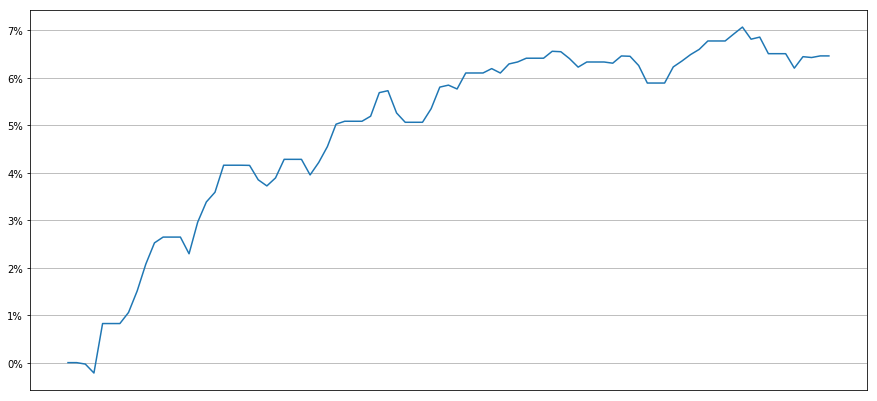

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_res
df = df.withColumn('date', to_timestamp(df.date, 'dd.MM.yyyy'))
pd_df = df.toPandas()

plt.figure(figsize=(15,7))
plt.plot(pd_df.performance_cumulee)

plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()]) 
plt.xticks([])

plt.axes().yaxis.grid()

plt.show()

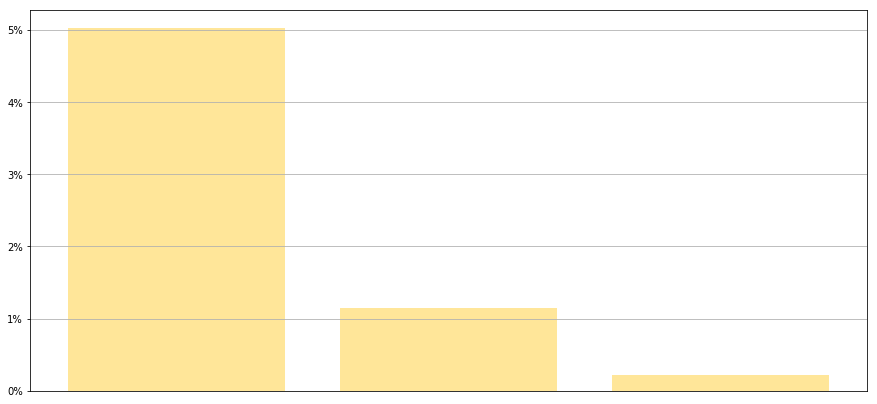

In [10]:
data = [['2019-01-31', 0.050228406], ['2019-02-28', 0.01144471], ['2019-03-29', 0.002225]]
pd_df = pd.DataFrame(data, columns=['date', 'performance_cumulee'])

plt.figure(figsize=(15,7))
plt.bar(pd_df.date, pd_df.performance_cumulee, color=('#ffe699'))

plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.xticks([])

plt.axes().yaxis.grid()

plt.show()

### Using Seaborn
Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

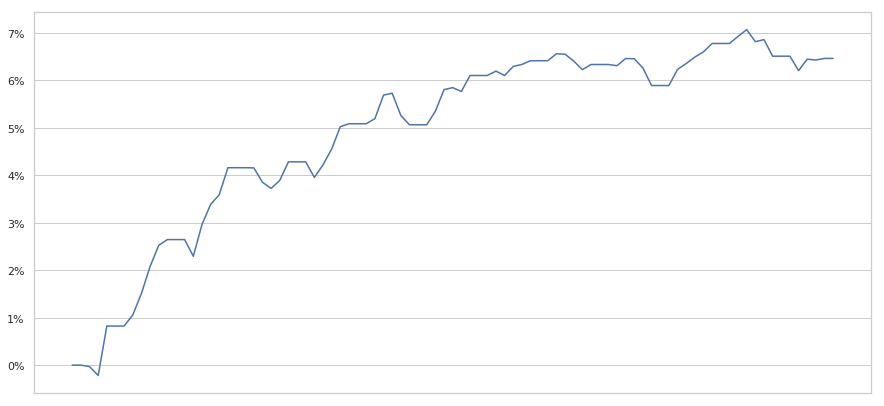

In [49]:
import seaborn as sb

df = df_res
df = df.withColumn('date', to_timestamp(df.date, 'dd.MM.yyyy'))
pd_df = df.toPandas()

sb.set_style('whitegrid')

plt.figure(figsize=(15, 7))

plt.plot(pd_df.date, pd_df.performance_cumulee)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xticks([])

plt.show()

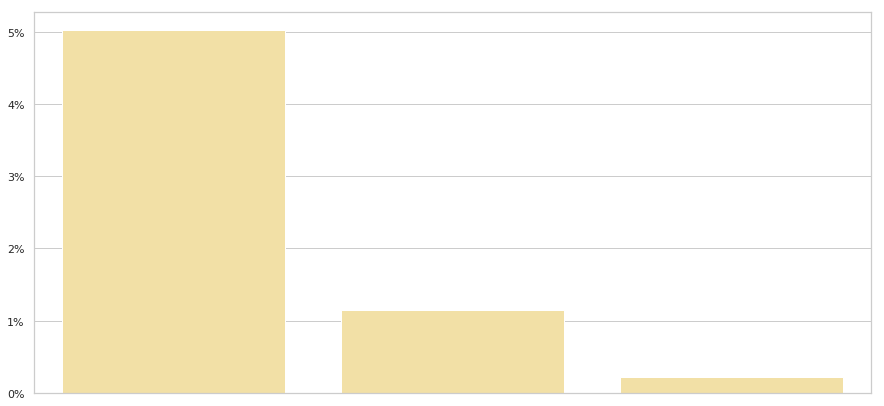

In [47]:
data = [['2019-01-31', 0.050228406], ['2019-02-28', 0.01144471], ['2019-03-29', 0.002225]]
pd_df = pd.DataFrame(data, columns=['date', 'performance_cumulee'])

plt.figure(figsize=(15, 7))

sb.set(style="whitegrid")
sb.barplot(y='performance_cumulee', x='date', data=pd_df, color='#ffe699')

plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()]) 
plt.xticks([])
plt.xlabel('')
plt.ylabel('')

plt.show()